In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [19]:
supply_data= pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')
supply_data['Date'] = pd.to_datetime(supply_data['Date'])
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)
supply_data.set_index('Date', inplace=True)

In [20]:


# Feature Selection (Supply is the target variable)
features = ['72 Day Temperature', '72 Day Precipitation']

target = 'Supply'

In [21]:
# Create input features (X) and target variable (y)
X = supply_data[features].values
y = supply_data[target].values.reshape(-1, 1)

# Normalize the features and target using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Define the window size (e.g., past 30 days to predict the next month)
window_size = 30

In [22]:
# Create sequences for LSTM input
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, window_size)

In [23]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]


In [24]:
# Build the LSTM model with increased complexity
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))


C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=150, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions
predictions = model.predict(X_test)



Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.1232 - val_loss: 0.0162
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0350 - val_loss: 0.0225
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0295 - val_loss: 0.0462
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0360 - val_loss: 0.0278
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0262 - val_loss: 0.0319
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0261 - val_loss: 0.0371
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0249 - val_loss: 0.0295
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0285 - val_loss: 0.0281
Epoch 9/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0227 - val_loss: 0.0179
Epoch 10/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0283 - val_loss: 0.0222
Epoch 11/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0252 - val_loss: 0.0239
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


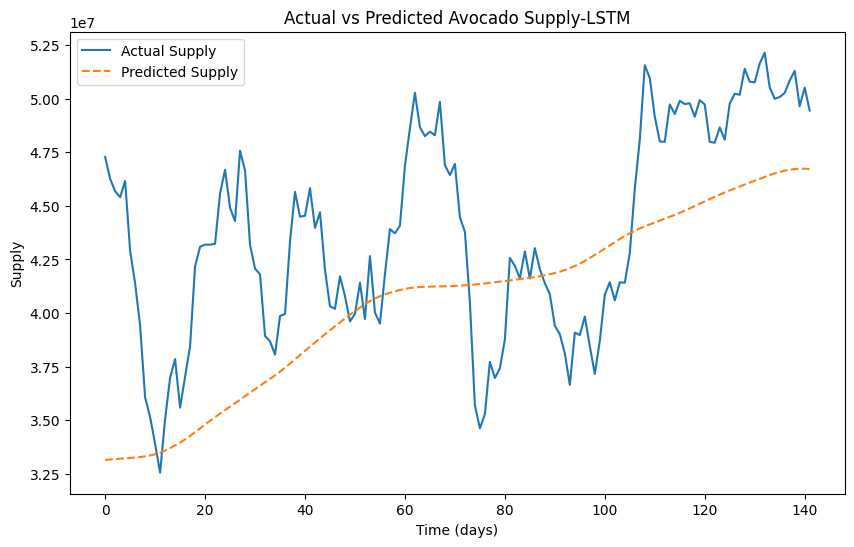

In [26]:
y_pred = scaler_y.inverse_transform(predictions)
y_actual = scaler_y.inverse_transform(y_test)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual Supply')
plt.plot(y_pred, label='Predicted Supply', linestyle='--')
plt.xlabel('Time (days)')
plt.ylabel('Supply')
plt.title('Actual vs Predicted Avocado Supply-LSTM')
plt.legend()
plt.show()

In [27]:
def forecast_next_month(model, X_last_sequence, n_days=30):
    X_input = X_last_sequence.copy()
    forecast = []
    for _ in range(n_days):
        prediction = model.predict(np.expand_dims(X_input, axis=0))
        forecast.append(prediction[0])
        X_input = np.append(X_input[1:], prediction, axis=0)
        X_input = X_input.reshape(window_size, -1)  # Ensure X_input has the correct shape
    forecast = scaler_y.inverse_transform(forecast)
    return forecast

In [28]:
# Use the last available sequence for forecasting
X_last_sequence = X_scaled[-window_size:]
forecast = forecast_next_month(model, X_last_sequence)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(forecast, label='Forecasted Supply for Next Month', linestyle='--')
plt.xlabel('Time (days)')
plt.ylabel('Supply')
plt.title('Forecasted Avocado Supply for Next Month')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 1